In [1]:
import numpy as np
from utils import *

import networkx as nx
from factor import Factor
from typing import List

This notebook is my sketchpad to develop an understanding of how belief propagation works, with the eventual goal of having a belief propagation algorithm for tensor networks. The steps to get there are as follows:
1. Write a simple, basic belief propagation algorithm and try out on different graphs (use `networkx` handling graphs)
2. Write a belief propagation algorithm for tensor networks (use `quimb` for tensor networks) following the paper [arXiv:2008.04433](https://arxiv.org/abs/2008.04433)

**Update**: I implemented variable elimination. Well, oops!

Network: {'a': ['i', 'j'], 'c': ['j', 'k', 'l', 'm'], 'b': ['k'], 'd': ['l', 'm', 'n']}


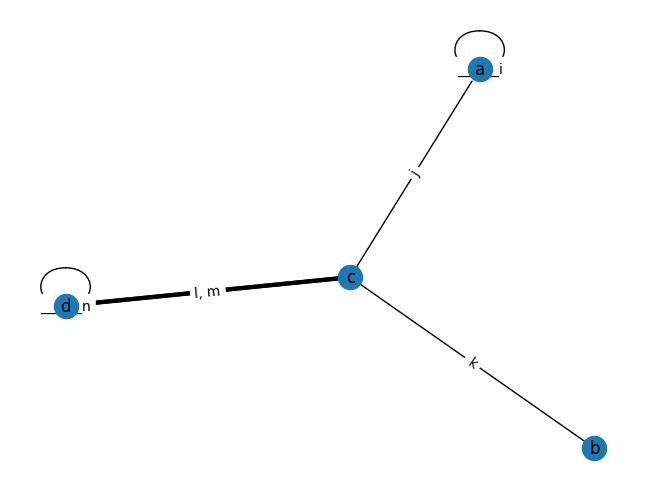

In [2]:
# Here is a network to work with

def construct_graph_from_edges(edges):
    """ Constructs a graph from a list of edges. Every edge is a tuple of the form (node1, node2, size). The tensor at each node is initialized to a random tensor of the corresponding shape. """

    def get_edge_data(graph, node, sort_by=0):
        """ Finds all edges connected to the given node and returns their corresponding data. """
        edges = []
        for n in graph.neighbors(node):
            for e, e_data in graph.get_edge_data(node, n).items():
                edges.append(list(e_data.values()))
        return np.unique(edges, axis=sort_by).T

    graph = nx.MultiGraph()
    for i, edge in enumerate(edges):
        var_label = chr(ord('i') + i)
        graph.add_edge(edge[0], edge[1], var=var_label, size=edge[2])

    for n in list(graph.nodes):
        variables, sizes = get_edge_data(graph, n)
        variables, sizes = list(variables), [int(s) for s in sizes]
        tensor = normalize(np.random.rand(*sizes), p=1, axis=0)
        graph.add_node(n, factor=Factor(variables, tensor))

    return graph

def draw_graph(graph):
    def get_edge_labels(graph):
        edge_labels = {}
        for i, j, d in graph.edges(data=True):
            if (i,j) in edge_labels:
                edge_labels[(i,j)] += f", {d['var']}"
            else:
                edge_labels[(i,j)] = str(d['var'])
        for (i, j), s in edge_labels.items():
            if i == j:
                edge_labels[(i,j)] = "______" + s
        return edge_labels

    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, with_labels=True, width=[3**(graph.number_of_edges(i,j)-1) for i, j, d in graph.edges(data=True)])
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=get_edge_labels(graph))

edges = [('a', 'a', 2), ('a', 'c', 2), ('b', 'c', 3), ('c', 'd', 2), ('c', 'd', 3), ('d', 'd', 2)] # each edge corresponds to a variable / index (networkx doesn't support hyperedges)
net = construct_graph_from_edges(edges)
draw_graph(net)
print("Network:", {n :d['factor'].variables for n, d in net.nodes(data=True)})

None

Network: {'A': ['A'], 'AB': ['A', 'B'], 'C': ['C'], 'BCD': ['B', 'C', 'D'], 'DE': ['D', 'E'], 'DF': ['D', 'F']}


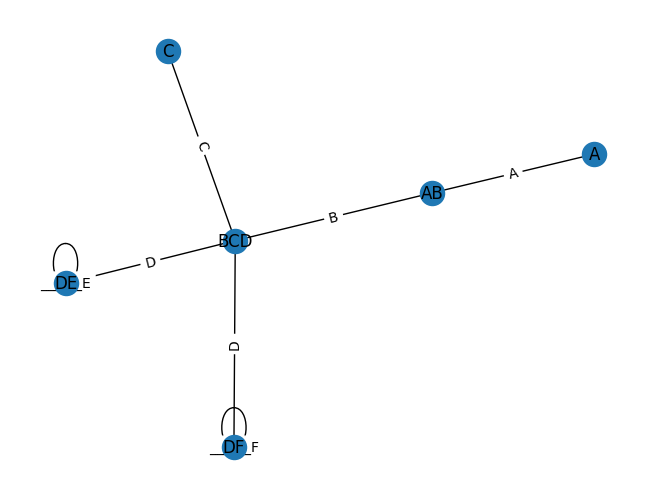

In [44]:
def construct_graph_from_factors(factors: List[Factor]):
    """ Constructs a graph from a list of factors. Every factor is a tuple of the form (variables, tensor). """
    graph = nx.MultiGraph()
    for i, factor in enumerate(factors):
        # node_label = chr(ord('a') + i)
        node_label = ''.join(factor.variables)
        graph.add_node(node_label, factor=factor)

    for i, factor in enumerate(factors):
        # Find the node that contains the factor
        node = None
        for n, d in graph.nodes(data=True):
            if d['factor'] == factor:
                node = n
                break
        if node is None:
                raise Exception("Could not find node for factor:", factor)
        for v in factor.variables:
            for other_factor in factors:
                if v in other_factor.variables and other_factor != factor:
                    # print(f"{''.join(factor.variables)}: Found {v} in {''.join(other_factor.variables)}")
                    # Find the node that contains the other factor
                    other_node = None
                    for n, d in graph.nodes(data=True):
                        if d['factor'] == other_factor:
                            other_node = n
                            break
                    if  other_node is None:
                        raise Exception("Could not find node for factor:", other_factor)
                    # Add an edge between the two nodes if there is not already the opposite edge
                    if not (graph.has_edge(node, other_node) or graph.has_edge(other_node, node)):
                        graph.add_edge(node, other_node, var=v, size=factor.data.shape[factor.variables.index(v)])
            # If there is no other, add a self-loop
            if not any([v in other_factor.variables for other_factor in factors if other_factor != factor]):
                # print(f"{''.join(factor.variables)}: Found {v} in no other factor")
                graph.add_edge(node, node, var=v, size=factor.data.shape[factor.variables.index(v)])

    return graph

# This is the tree in Barber Figure 14.1 and 14.2
net_barber = construct_graph_from_factors([
    Factor('A', np.array([0.01, 0.99])),
    Factor('AB', np.array([[0.1, 0.9], [0.001, 0.999]])),
    Factor('C', np.array([0.001, 0.999])),
    Factor('BCD', np.array([[[0.99, 0.01], [0.9, 0.1]], [[0.95, 0.05], [0.01, 0.99]]])),
    Factor('DE', np.array([[0.9, 0.1], [0.3, 0.7]])),
    Factor('DF', np.array([[0.2, 0.8], [0.1, 0.9]])),
])
# remove edge between 'DE' and 'DF'
net_barber.remove_edge('DE', 'DF')
draw_graph(net_barber)
print("Network:", {n :d['factor'].variables for n, d in net_barber.nodes(data=True)})

In [4]:
# Here is an attempt to add tensors to both nodes and edges
# tree = nx.Graph()

# nodes = [(0, 2), (1, 2), (2, 2), (3, 2), (4, 2), (5, 2)]
# edges = [(0, 1), (0, 2), (1, 3), (1, 4), (2, 5)]
# # add a size attribute to each node
# for node, size in nodes:
#     tree.add_node(node, size=size, f=np.random.rand(size))
# # add a tensor to each edge as an attribute with the size of the respective nodes
# for i,j in edges:
#     f = np.random.rand(tree.nodes[i]['size'], tree.nodes[j]['size'])
#     # tensor = normalize(tensor, 1, axis=1)
#     tree.add_edge(i, j, f=f)

# 1. Variable elimination

In [54]:
def variable_elimination(graph, query, evidence=None, elimination_ordering=None):
    """
        Computes the marginals for given variables, given optional evidence.
        By replacing the terms "factor" with "tensor" and "variable" with "index", this is the same as the simple update algorithm for a tensor network.

        Parameters
            graph (nx.Graph): The graph for which the marginals should be computed.
            Each node should have the attribute 'factor' containing a Factor object, and each edge should have 
            an attribute 'var' containing the name of the variable present the in factors connected by the edge.

            query (list[str]): A list of variables for which the marginals should be computed

            evidence (dict, optional): A dictionary containing node: outcome pairs to specify the 
            state of the given variables

            elimination_ordering (list[str], optional): A list of node names specifying the order. If `None`

        Returns
            np.ndarray: An array containing the marginals for the given nodes
    """

    # Init: get all factors containing the query variables (we don't need the rest)
    Phi = []
    for n, n_data in graph.nodes(data=True):
        f = n_data['factor']
        # check if the factor contains any of the query variables
        # if np.any([v in f.variables for v in query]):
        Phi.append(f)
    # if len(Phi) == 0:
    #     raise ValueError("No factors containing the query variables were found.")

    # 1. reduce factors by their evidence
    if evidence is not None:
        Phi = [f.reduce(evidence) for f in Phi]

    # 2. get the elimination ordering (this step is NP-hard, so the default is gonna be bad)
    if elimination_ordering is None:
        # just use the default ordering of the graph edge list
        elimination_ordering = [data['var'] for i,j, data in graph.edges(data=True)]

    # 3. Eliminate all non-query variables
    for x in [x for x in elimination_ordering if x not in query]:
        # 4. get all factors containing the variable x
        Phi_x = [phi for phi in Phi if x in phi.variables]
        if len(Phi_x) == 0:
            # this variable is not contained in any factor, so we can skip it
            continue

        # 5.1 Pass the messages: Multiply all factors containing x
        phi_x = Factor()
        for f in Phi_x:
            phi_x = phi_x * f

        # 5.2 Aggregate: Marginalize x
        phi_x = phi_x.marginalize(x)

        # 6. Update Phi
        Phi = [phi for phi in Phi if x not in phi.variables] + [phi_x]

    # 8. Multiply all remaining factors
    res = Factor()
    for phi in Phi:
        res = res * phi

    # Normalize
    res.transpose(query, inplace=True)
    res.normalize(inplace=True)

    return res

variable_elimination(net, 'ij'), variable_elimination(net_barber, 'C')

(Factor: ['i', 'j'] (2, 2) [[0.38262394 0.23394399]
  [0.1136296  0.26980246]],
 Factor: C (2,) [0.001 0.999])

# 2. Variable elimination for tensor networks

In [55]:
import quimb as qu
import quimb.tensor as qtn

In [7]:
def tn_mul(t1, t2):
        """ Multiply two tensors element-wise, adding new indices if necessary. New indices are initialized to 1. """
        def add_indices(target, like):
            """ Add all indices of `like` to `target` if they are not already present. """
            for i in reversed(like.inds):
                if i not in target.inds:
                    target.new_ind(i, size=0, axis=-1) # size 0 is a placeholder and will be updated later automatically

        t1 = t1.copy()
        t2 = t2.copy()
        # add all extra indices of t2 to t1 and vice versa
        add_indices(target=t1, like=t2)
        add_indices(target=t2, like=t1)
        # ensure t2 indices have the same order as t1 indices
        t2.transpose(*t1.inds, inplace=True)
        # elementwise multiplication
        return t1 * t2

# Equivalent to `variable_elimination` above, but using `quimb.tensor.TensorNetwork` instead of `networkx.Graph`
def variable_elimination_tn(tn, query, elimination_ordering=None):
    """ Computes the marginals for given indices in `query`. We ignore evidence for now. """
    # Init: get all factors containing the query variables (we don't need the rest)
    Phi = [phi for phi in tn.tensors if np.any([v in phi.inds for v in query])]
    if len(Phi) == 0:
        raise ValueError("No factors containing the query variables were found.")

    # 1. get the elimination ordering (this step is NP-hard, so the default is gonna be bad)
    if elimination_ordering is None:
        # just use the default ordering of the graph edge list
        elimination_ordering = list(T.ind_map.keys())

    # 2. Eliminate all non-query variables
    for x in [x for x in elimination_ordering if x not in query]:
        # 3. get all factors containing the variable x
        Phi_x = [phi for phi in Phi if x in phi.inds]
        if len(Phi_x) == 0:
            # this variable is not contained in any factor, so we can skip it
            continue

        # 4.1 Pass messages: Multiply all factors containing x
        phi_x = qtn.Tensor()
        for f in Phi_x:
            phi_x = tn_mul(phi_x, f)

        # 4.2 Aggregate: Marginalize x
        phi_x = phi_x.sum_reduce(x)

        # 5. Update Phi
        Phi = [phi for phi in Phi if x not in phi.inds] + [phi_x]

    # 6. Multiply all remaining factors
    res = qtn.Tensor()
    for phi in Phi:
        res = tn_mul(res, phi)

    # Normalize
    res.transpose(*query, inplace=True)
    res = res / res.data.sum()

    return res

def get_tn(graph):
    """ Returns a tensor network from the given graph. """
    T = qtn.TensorNetwork()
    for n, n_data in graph.nodes(data=True):
        tensor = qtn.Tensor(n_data['factor'].data, inds=n_data['factor'].variables, tags=n)
        T |= tensor
    return T

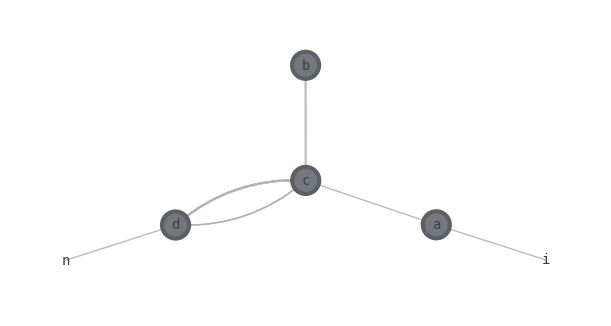

Tensor(shape=(2, 3), inds=('i', 'm'), tags=oset(['d', 'a', 'c']))

In [8]:
# Define a tensor network from the graph `net`
T = get_tn(net)
T.draw()
query = 'im'

assert np.allclose(variable_elimination(net, query).data, variable_elimination_tn(T, query).data)

variable_elimination_tn(T, query)

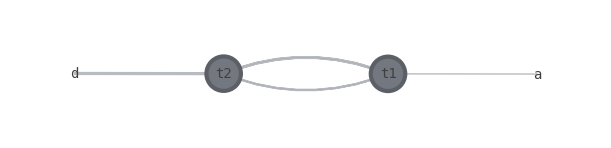

In [62]:
t1 = qtn.Tensor(np.random.rand(2, 3, 4), inds='abc', tags='t1')
t2 = qtn.Tensor(np.random.rand(3, 4, 5), inds='bcd', tags='t2')
(t1 | t2).draw()